In [2]:
import pickle
import numpy as np
from multigraph import MultiGraph

with open('adj_graph.pkl', 'rb') as inobj:
    op_graph = pickle.load(inobj)

In [3]:
import keras
from keras.models import Sequential, Model, model_from_json, load_model
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Activation
from keras.regularizers import l2, l1

#load the saved embeddings
#model = load_model('rgcn_model.h5', custom_objects={'GraphConvolution': GraphConvolution})

with open('coding_model.json','r') as f:
    json = f.read()
model = model_from_json(json)
model.load_weights("coding_model.h5")

print("Loaded model from disk")

Using TensorFlow backend.


Loaded model from disk


In [4]:
embedding = model.predict(op_graph.get_adjacency_matrix())

In [5]:
# Each node in the AIFB dataset is either a person, a project, a publication, a group, etc.
# Here we get a list of all of the nodes that have a certain label and put them in a dictionary
import re
publications = re.compile("<(http:\/\/www\.aifb\.uni-karlsruhe\.de\/Publikationen\/viewPublikationOWL\/id[0-9]*instance)>")
authors = re.compile("<(http:\/\/www\.aifb\.uni-karlsruhe\.de\/Personen\/viewPersonOWL\/id[0-9]*instance)>")
groups = re.compile("<(http:\/\/www\.aifb\.uni-karlsruhe\.de\/Forschungsgruppen\/viewForschungsgruppeOWL\/id[0-9]*instance)>")
projects = re.compile("<(http:\/\/www\.aifb\.uni-karlsruhe\.de\/Projekte\/viewProjektOWL\/id[0-9]*instance)>")
subjects = re.compile("<(http:\/\/www\.aifb\.uni-karlsruhe\.de\/Forschungsgebiete\/viewForschungsgebietOWL\/id[0-9]*instance)>")
organizations = re.compile("<(http:\/\/www\.aifb\.uni-karlsruhe\.de\/Kooperationen\/viewOrganizationOWL\/id[0-9]*instance)>")

regex_dict = {"publications":publications, "authors":authors, 
              "groups":groups, "projects": projects, "subjects": subjects,
              "organizations":organizations}

from collections import defaultdict
categories = defaultdict(set)

In [6]:
with open("aifb_csv/aifb_stripped.nt") as f:
    for line in f:
        for k,reg in regex_dict.iteritems():
            finds = reg.match(line)
            if finds != None:
                categories[k].add(finds.group(1))

for k,v in categories.iteritems():
    print(k,len(v))

('organizations', 28)
('subjects', 146)
('publications', 1232)
('groups', 5)
('authors', 237)
('projects', 78)


In [7]:
import random
#get the embeddings for 100 instances from each category
subset_embeddings = defaultdict(list)
label_enum = list(enumerate(categories.keys(),1))
label_dict = {j: i for i,j in label_enum}

for k,v in categories.iteritems():
    samples = random.sample(v, min(len(v), 100))
    for s in samples:
        #print(s,embedding[op_graph.nodes[s]])
        subset_embeddings[k].append(embedding[op_graph.nodes[s]])
print(label_enum)

[(1, 'organizations'), (2, 'subjects'), (3, 'publications'), (4, 'groups'), (5, 'authors'), (6, 'projects')]


In [8]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
import gensim


#from https://medium.com/@aneesha/using-tsne-to-plot-a-subset-of-similar-words-from-word2vec-bb8eeaea6229
def tsnescatterplot(vector_dict, labels):
    #flatten the dictionary into two lists
    vectors = []
    vector_labels = []
    for k,v in vector_dict.iteritems():
        i = [l[0] for l in labels if l[1] == k]
        for s in v:
            vectors.append(s)
            vector_labels.append(i[0])
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(vectors)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    
    # display scatter plot   
    cmap = plt.cm.rainbow
    norm = mcolors.Normalize(vmin=0, vmax=len(labels))
    plt.figure(figsize=(8,6),dpi=200)
    plt.scatter(x_coords, y_coords, alpha=0.85, c=[cmap(norm(i)) for i in vector_labels])
    #draw the legend
    patches = []
    for l in labels:
        if l[1] in vector_dict:
            patches.append(mpatches.Patch(color=cmap(norm(l[0])), label=l[1]))
    plt.legend(handles=patches)
    #scatterpoints=1, loc='lower left', ncol=3, fontsize=8

    #for label, x, y in zip(vector_labels, x_coords, y_coords):
    #    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()-5.5, x_coords.max()+5.5)
    plt.ylim(y_coords.min()-5.5, y_coords.max()+5.5)
    plt.show()


In [9]:
import umap

def umapscatterplot(vector_dict, labels):
    #flatten the dictionary into two lists
    vectors = []
    vector_labels = []
    for k,v in vector_dict.iteritems():
        i = [l[0] for l in labels if l[1] == k]
        for s in v:
            vectors.append(s)
            vector_labels.append(i[0])
    # find tsne coords for 2 dimensions
    umapper = umap.UMAP()
    np.set_printoptions(suppress=True)
    Y = umapper.fit_transform(vectors)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    
    # display scatter plot   
    cmap = plt.cm.rainbow
    norm = mcolors.Normalize(vmin=0, vmax=len(labels))
    plt.figure(figsize=(8,6),dpi=200)
    plt.scatter(x_coords, y_coords, alpha=0.85, c=[cmap(norm(i)) for i in vector_labels])
    #draw the legend
    patches = []
    for l in labels:
        if l[1] in vector_dict:
            patches.append(mpatches.Patch(color=cmap(norm(l[0])), label=l[1]))
    plt.legend(handles=patches)
    #scatterpoints=1, loc='lower left', ncol=3, fontsize=8

    #for label, x, y in zip(vector_labels, x_coords, y_coords):
    #    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()-5.5, x_coords.max()+5.5)
    plt.ylim(y_coords.min()-5.5, y_coords.max()+5.5)
    plt.show()

In [10]:
from sklearn.decomposition import PCA

def pcascatterplot(vector_dict, labels):
    #flatten the dictionary into two lists
    vectors = []
    vector_labels = []
    for k,v in vector_dict.iteritems():
        i = [l[0] for l in labels if l[1] == k]
        for s in v:
            vectors.append(s)
            vector_labels.append(i[0])
    # find tsne coords for 2 dimensions
    pca = PCA(n_components=2)
    np.set_printoptions(suppress=True)
    Y = pca.fit_transform(vectors)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    
    cmap = plt.cm.rainbow
    norm = mcolors.Normalize(vmin=0, vmax=len(labels))
    # display scatter plot
    plt.figure(figsize=(8,6),dpi=200)
    plt.scatter(x_coords, y_coords,alpha=0.5, c=[cmap(norm(i)) for i in vector_labels])
    
   #draw the legend
    patches = []
    for l in labels:
        if l[1] in vector_dict:
            patches.append(mpatches.Patch(color=cmap(norm(l[0])), label=l[1]))
    plt.legend(handles=patches)
    #scatterpoints=1, loc='lower left', ncol=3, fontsize=8
    
    #for label, x, y in zip(vector_labels, x_coords, y_coords):
    #    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()-5.5, x_coords.max()+5.5)
    plt.ylim(y_coords.min()-5.5, y_coords.max()+5.5)
    plt.show()

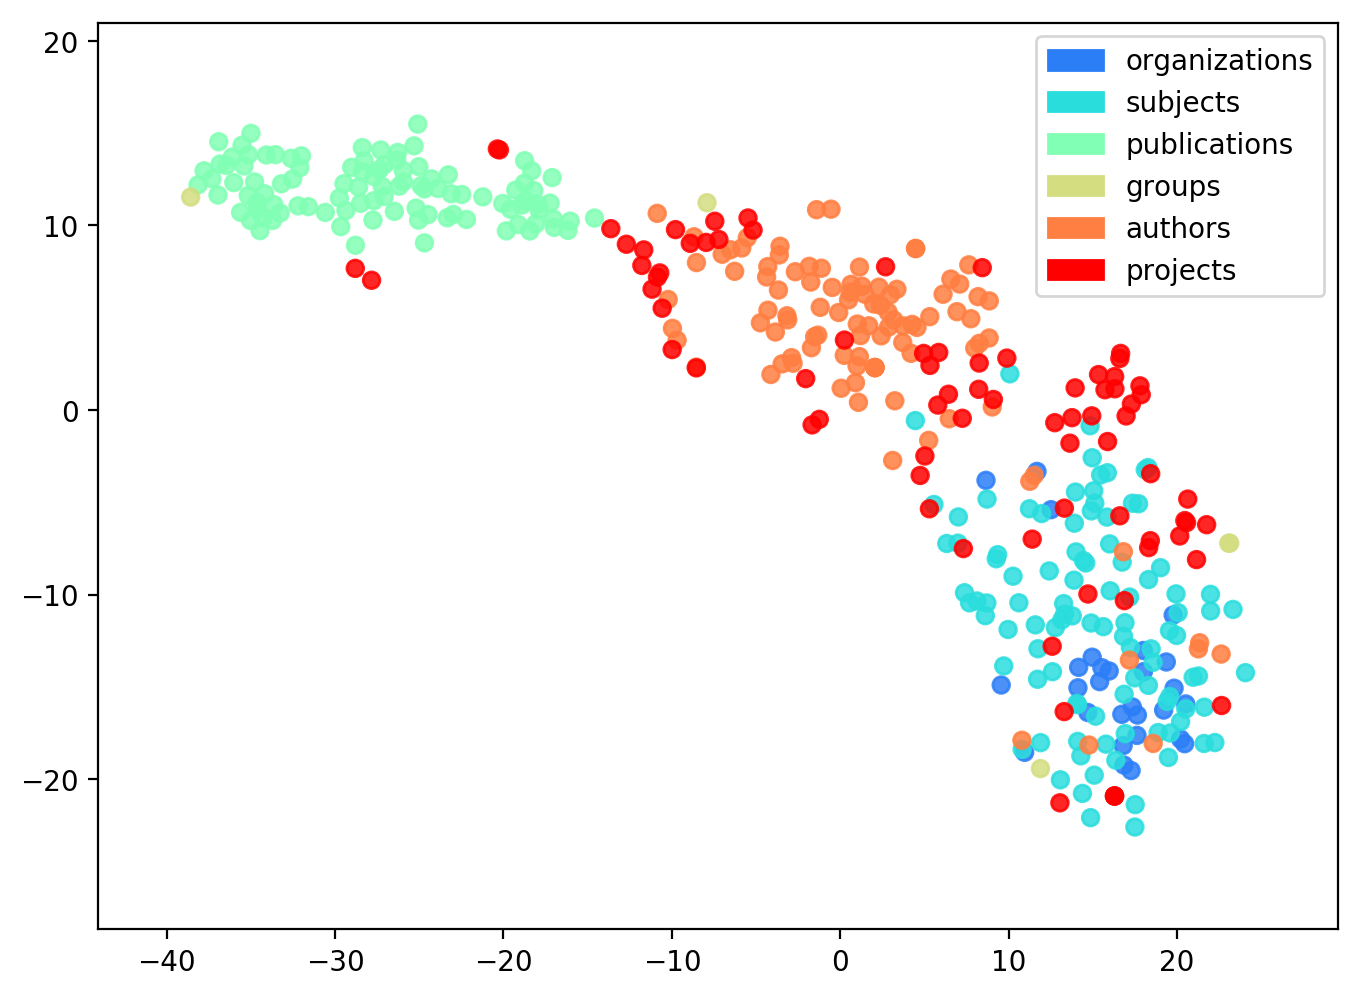

In [11]:
tsnescatterplot(subset_embeddings, label_enum)

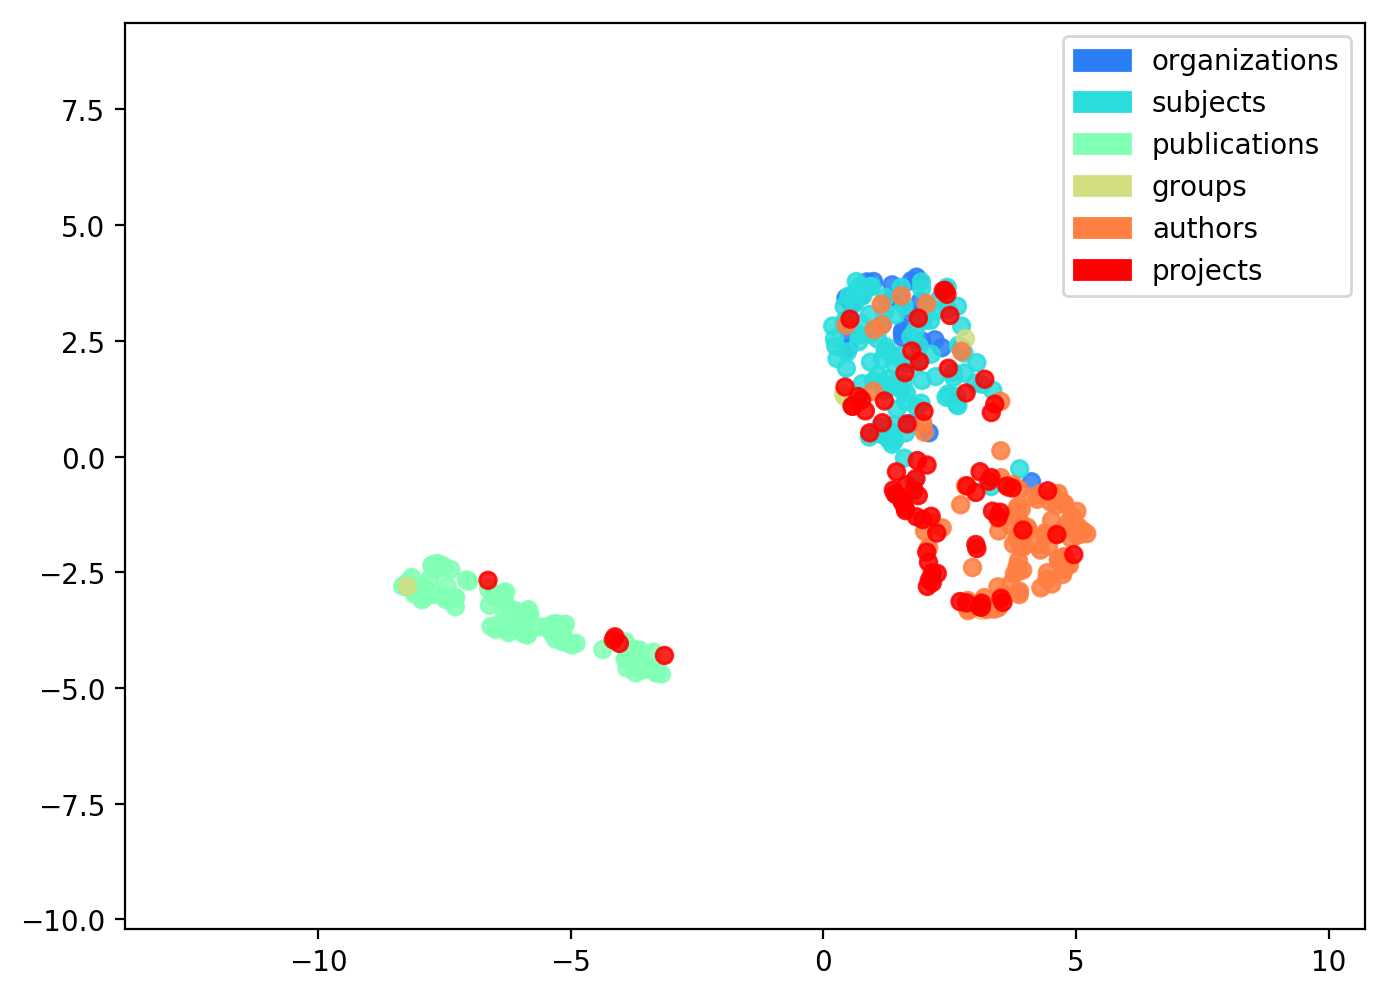

In [12]:
umapscatterplot(subset_embeddings, label_enum)

In [ ]:
import unicodecsv as csv

def get_class_embeddings(full_embeddings, graph, filename):
    sub_dict = defaultdict(list)
    with open(filename, 'r') as csvfile:
        graphreader = csv.reader(csvfile)
        i = 0
        for row in graphreader:
            if i == 0:
                i += 1
                continue
            sub_dict[row[1].rsplit('/',2)[-1]].append(row[0])

    print("Number of instances in each label:")
    for k,v in sub_dict.iteritems():
        print(k,len(v))
    #get the embeddings for each of the classes in the sub_dict
    subset_embeddings = defaultdict(list)
    #subset_labels = []
    label_enum = list(enumerate(sub_dict.keys(),1))
    #label_dict = {j: i for i,j in label_enum}

    for k,v in sub_dict.iteritems():
        for s in v:
            subset_embeddings[k].append(full_embeddings[graph.nodes[s]])
            #subset_labels.append(label_dict[k])
    print("enumerating the labels:")
    print(label_enum)
    return (subset_embeddings, label_enum)

In [ ]:
# The AIFB dataset has 176 people and they are associated with one of four affiliations in the organization.
# The completeSet.tsv file gives the URIs of the people and their affiliation
# (number, person, affiliation)

subset_embeddings, label_enum = get_class_embeddings(embedding,op_graph,'aifb_csv/completeDataset.csv')

In [ ]:
tsnescatterplot(subset_embeddings, label_enum)

In [ ]:
umapscatterplot(subset_embeddings, label_enum)

In [ ]:
subset_embeddings, label_enum = get_class_embeddings(embedding,op_graph,'aifb_csv/project_carried_out.csv')

In [ ]:
tsnescatterplot(subset_embeddings, label_enum)

In [ ]:
umapscatterplot(subset_embeddings, label_enum)

In [ ]:
finance_embeddings, finance_enum = get_class_embeddings(embedding,op_graph,'aifb_csv/projects_financed.csv')

In [ ]:
# Only use the financial sources that financed more than 3 projects
finance_embeddings = {k: v for k, v in finance_embeddings.iteritems() if len(v) > 3}
print("number of instances in each label:")
for k,v in finance_embeddings.iteritems():
    print (k,len(v))
finance_enum = list(enumerate(finance_embeddings.keys(),1))

In [ ]:
tsnescatterplot(finance_embeddings, finance_enum)

In [ ]:
umapscatterplot(finance_embeddings, finance_enum)